In [1]:
"""
THIS NOTEBOOK LOADS 
    - THE VAE (ENCODES THE MOTOR+VISUAL INTO A LATENT STATE) AND RNN (USES THE LATENT STATE
      AS THE INITIAL HIDDEN STATE) MODELS
    - WEIGHTS TRAINED BY VAE_encode_vid_motor_TEST
    - USES THESE MODELS TO CONTROLS THE PHYSICAL ROBOT
"""

'\nTHIS NOTEBOOK LOADS \n    - THE VAE (ENCODES THE MOTOR+VISUAL INTO A LATENT STATE) AND RNN (USES THE LATENT STATE\n      AS THE INITIAL HIDDEN STATE) MODELS\n    - WEIGHTS TRAINED BY VAE_encode_vid_motor_TEST\n    - USES THESE MODELS TO CONTROLS THE PHYSICAL ROBOT\n'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from __future__ import print_function
import sys, os, time, pickle, rospy

from enum import Enum
import random
from torobo_driver import torobo_easy_command

import numpy as np
from scipy import signal
import scipy

from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# wrapper/helper functions
sys.path.insert(0, '/home/torobo/catkin_ws/src/torobo_robot/torobo_rnn/scripts')
sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')

image_topic = "/camera/color/image_raw" # Real-Robot

from torobo_rnn_utils__upd3 import *
from detect_upd import Recog, Recog2

with HiddenPrints():
    plt.switch_backend('nbAgg')

    bridge = CvBridge()
    torobo = ToroboOperator()
    


class ExtForce(object):
    # SETS THE KINEMATIC MODEL PARAMETERS (BOTH IN HENDRY'S AND FACTORY FIRMWARE)

    class Mode(Enum):
        Teaching = 0
        Experiment = 1

    def runCommands(self, _commandList, _controller):
          for command in _commandList:
                torobo_easy_command.SendEasyCommandText(_controller, command)
                rospy.sleep(0.01)

    def registerParameters(self, tau_th, kp, sum_e_max, d, kr, theta_th):
            # left and right arm 
            for i in range(0,6):
                
                # constructing the commands for the left arm
                commandList = []				
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[i]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[i]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[i]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[i]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[i]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[i]))	


                # send to execution
                self.runCommands(commandList, "left_arm_controller")

            # right arm 
            for i in range(0,6):
                ii = i + 6 
                # constructing the commands for the right arm
                commandList = []
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[ii]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[ii]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[ii]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[ii]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[ii]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[ii]))	

                # send to execution
                self.runCommands(commandList, "right_arm_controller")
                            
            for i in range(0,4):
                ii = i + 12 
                # constructing the commands for the head-torso chain
                commandList = []				
                commandList.append("param " + str(i+1) + " fftauth " +       str(tau_th[ii]))
                commandList.append("param " + str(i+1) + " ffkp " +          str(kp[ii]))
                commandList.append("param " + str(i+1) + " ffsigmaemax " +   str(sum_e_max[ii]))
                commandList.append("param " + str(i+1) + " ffdamping " +     str(d[ii]))
                commandList.append("param " + str(i+1) + " ffkr " +          str(kr[ii]))
                commandList.append("param " + str(i+1) + " softki " +        str(theta_th[ii]))	

                # send to execution
                self.runCommands(commandList, "torso_head_controller")


    def __init__(self, _mode):	
        
        if _mode == ExtForce.Mode.Teaching:

            tau_th = [2.0, 2.0, 1.0, 1.0, 0.5, 0.5,            2.0, 2.0, 1.0, 1.0, 0.5, 0.5,      20.5, 20.5, 20.5, 20.5]
            kp = [0.1, 0.1, 0.05, 0.05, 0.1, 0.1,            0.1, 0.1, 0.05, 0.05, 0.1, 0.1,        0.0,0.0,0.0,0.0]
            sum_e_max = [200.0,200.0,100.0,100.0,50.0,50.0,  200.0,200.0,100.0,100.0,50.0,50.0,   200.0,200.0,50.0,50.0]
            d = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            # kr = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
            kr = [0.1]*16
            kr[5] = 0.3
            kr[11] = 0.3
            theta_th = [1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57]
            theta_th = [i*1.63 for i in theta_th]

            self.registerParameters( tau_th, kp, sum_e_max, d, kr, theta_th)


        elif _mode == ExtForce.Mode.Experiment:

            tau_th = [12.0,12.0,5.0,5.0,1.5,1.5,12.0,12.0,5.0,5.0,1.5,1.5,200.0,200.0,200.0,200.0]
            kp = [0.025,0.025,0.05,0.05,0.1,0.1,0.025,0.025,0.05,0.05,0.1,0.1,0.025,0.025,0.05,0.05]
            sum_e_max = [200.0,200.0,100.0,100.0,50.0,50.0,200.0,200.0,100.0,100.0,50.0,50.0,200.0,200.0,50.0,50.0]
            d = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            kr = [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8]
            # kr = [0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]
            theta_th = [1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57,1.57]
            theta_th = [i*1.63 for i in theta_th]

            self.registerParameters( tau_th, kp, sum_e_max, d, kr, theta_th)


In [2]:
# SET ALL JOINTS TO POSITION (FOR MAINTENANCE)

with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
    torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')

In [3]:
# SET ALL JOINTS TO ExtFF (FOR MAINTENANCE)

with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following');
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following');

In [4]:
# with HiddenPrints():
#     servo_on(torobo)
#     time.sleep(0.5)
#     torobo.set_control_mode(ToroboOperator.LEFT_ARM,
#                         'all',
#                         'external_force_following_online_trajectory')

#     torobo.set_control_mode(ToroboOperator.RIGHT_ARM,
#                             'all',
#                             'external_force_following_online_trajectory')

#     torobo.set_control_mode(ToroboOperator.TORSO_HEAD,
#                             ['torso_head/joint_3', 'torso_head/joint_4'],
#                             'external_force_following_online_trajectory')
    
#     set_softness_override(torobo, 10.0)
#     set_velocity_override(torobo, 10.0)

In [5]:
# SET THE NEEDED KINEMATIC PARAMETERS AND MODES, OVERRIDES ON THE RIGHT JOINTS

with HiddenPrints():
    set_external_force_following_online_trajectory_control(torobo)
#     set_position_control(torobo)
    torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
print('SETTING MODE: set_external_force_following_online_trajectory_control')
with HiddenPrints():
    time.sleep(1)
    ExtForce(ExtForce.Mode.Teaching)
    time.sleep(1)
print('SETTING DYNAMIC PARAMETERS')

with HiddenPrints():
    set_softness_override(torobo, 10.0)
    set_velocity_override(torobo, 10.0)
print('OVERRIDES SET')

SETTING MODE: set_external_force_following_online_trajectory_control
SETTING DYNAMIC PARAMETERS
OVERRIDES SET


In [66]:
# Go to the START position

idx = 4
TIME = 5

try:
    with HiddenPrints():
        set_softness_override(torobo, 10.0)
        set_velocity_override(torobo, 10.0)
        with open('rad.pickle', 'rb') as f:
            RAD = pickle.load(f)

        left_arm_positions = RAD[idx][0:6]
        right_arm_positions = RAD[idx][6:12]
        torso_head_positions = RAD[idx][12:16]

        torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
        torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
        torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
        rospy.sleep(TIME+0.1)
    print('SUCCESS')
except:
    print('ERROR')

SUCCESS


In [67]:
# START VIDEO FEED

if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

while True:
    cv2.imshow('I see', cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break

In [68]:
# DEFINE MODELS AND LOAD PRETRAINED WEIGHTS

class RNNe(nn.Module):
    def __init__(self, cell_type, motor_input_size, hidden_size, num_rnn_layers):
        super(RNNe, self).__init__()                  # extend the functionality of previously built classes.
        self.cell_type = cell_type
        self.num_rnn_layers = num_rnn_layers

        # YOU CAN USE EITHER LSTM, GRU OR VANILLA RNN
        if self.cell_type=='GRU':
            self.rnn_cell = nn.GRU(input_size=hidden_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='LSTM':
            self.rnn_cell = nn.LSTM(input_size=hidden_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='RNN':
            self.rnn_cell = nn.RNN(input_size=hidden_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
            
            
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=(1,1))
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=(1,1))
        
        self.fc1 =   nn.Linear(4096, 100)
        self.fc11 =  nn.Linear(100 + motor_input_size, hidden_size)
           
        self.fc2 =   nn.Linear(hidden_size, 1024)
        self.fc3 =   nn.Linear(hidden_size, motor_input_size)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=6, stride=2)


        self.optimizer = optim.Adam(self.parameters())        
    
       
    def forward(self, visual_input, motor_input, hidden):
        # visual pathway:
        out = F.relu(self.conv1(visual_input))                          # torch.Size([?, 7, 64, 64])
        out = F.relu(self.conv2(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv3(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv4(out))                                   # torch.Size([?, 28, 32, 32])

        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3])   # torch.Size([?, 7168])
        out = F.relu(self.fc1(out))                                     # torch.Size([?, 500])
        
        out = torch.cat((out, motor_input), dim=1).unsqueeze_(1)
        
        out = F.relu(self.fc11(out))
              
        
                      
        # run this combined input through an RNN cell (to predict the next visual input and motor state):
        out, hidden = self.rnn_cell(out, hidden)
        
        out1 = F.relu(self.fc2(out.squeeze()).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                               # torch.Size([?, 64])
        video_out = torch.sigmoid(self.deconv4(out1))                   # torch.Size([?, 64])
        
        # predict motor output based on the latent representation:
        motor_out = torch.tanh(self.fc3(out.squeeze()))

        return video_out, motor_out, hidden
    

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()                  # extend the functionality of previously built classes.

        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=(1,1))
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=(1,1))
        
        self.fc1 =   nn.Linear(4096, 100)
        
        self.fcmu = nn.Linear(116, latent_dim)
        self.fcsig = nn.Linear(116, latent_dim)
        
        self.fc2 =   nn.Linear(latent_dim, 1024)
        self.fc3 =   nn.Linear(latent_dim, 16)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=6, stride=2)


        self.optimizer = optim.RMSprop(self.parameters(), lr=0.00001)        
    
    def reparameterize(self, mu, logsig, train):
        std = torch.exp(logsig)*0.5                     # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        eps = torch.randn_like(std)
        return mu + eps*std if train else mu   

    def KL(self, mu, logsig):
        Dkl = - 0.5 * torch.sum(1.0 + logsig - mu.pow(2) - logsig.exp())
        return Dkl 
    
    def forward(self, visual_input, motor_input, train):
        # visual pathway:
        out = F.relu(self.conv1(visual_input))                          # torch.Size([?, 7, 64, 64])
        out = F.relu(self.conv2(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv3(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv4(out))                                   # torch.Size([?, 28, 32, 32])

        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3])   # torch.Size([?, 7168])
        out = F.relu(self.fc1(out))                                     # torch.Size([?, 500])
              
        vis_motor = torch.cat((out, motor_input), dim=1)
              
        mu = self.fcmu(vis_motor)                                       # torch.Size([?, 46])      
        logsig = self.fcsig(vis_motor)                                  # torch.Size([?, 46])
        
        latent = self.reparameterize(mu, logsig, train=train)           # torch.Size([?, 1, 46])
        
        out1 = F.relu(self.fc2(latent).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                               # torch.Size([?, 64])
        video_out = torch.sigmoid(self.deconv4(out1))                   # torch.Size([?, 64])
        
        # predict motor output based on the latent representation:
        motor_out = torch.tanh(self.fc3(latent))

        return video_out, motor_out, mu, logsig
    
    def reconstruct(self, mu):
        out1 = F.relu(self.fc2(mu).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                              # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                              # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                              # torch.Size([?, 64])
        out1 = torch.sigmoid(self.deconv4(out1))                       # torch.Size([?, 64])
        return out1

    
class Dataloader():
    def __init__(self):
        self.DAT = []
        self.TRAJECTORIES = ['RAD0.dat', 'RAD1.dat', 'RAD2.dat']
        for traj in self.TRAJECTORIES:
            with open(traj, 'rb') as f:
                self.DAT.append(pickle.load(f))
        
    def get_sample(self, device):

        dat = random.choice(self.DAT)

        # normalize the data and create inpus and targets for video
        trn_V = dat['img'][:-1,:,:,:]/255.
        trg_V = dat['img'][1:,:,:,:]/255.

        # ... and for joints
        trn_P = dat['joints'][:-1,:]/2.
        trg_P = dat['joints'][1:,:]/2.

        visual_input = torch.tensor(trn_V, dtype=torch.float).sum(axis=3).view(-1, 1, 64, 64).to(device)/3.
        motor_input = torch.tensor(trn_P, dtype=torch.float).view(-1, 16).to(device)
        visual_target = torch.tensor(trg_V, dtype=torch.float).sum(axis=3).view(-1, 1, 64, 64).to(device)/3.
        motor_target = torch.tensor(trg_P, dtype=torch.float).view(-1, 16).to(device)

        # return trn_V, trg_V, trn_P, trg_P
        return visual_input, motor_input, visual_target, motor_target 

    
latent_dim  = 20 # 4 for units to encode video (cube position), 16 to encode joints
device = 'cuda'
vae = VAE(latent_dim).to(device)
try:
    vae.load_state_dict(torch.load('checkpoint_vae_hidden_states_3'))
    print('Loading weights for the VAE succeeded')
except:
    print('Loading weights for the VAE failed')
    
motor_input_size= 16
hidden_size = 20
cell_type = 'GRU'
num_rnn_layers = 1

rnn = RNNe(cell_type, motor_input_size, hidden_size, num_rnn_layers).to(device)
try:
    rnn.load_state_dict(torch.load('checkpoint_rnn_new_3'))
    print('Loading weights for the RNN succeeded')
except:
    print('Loading weights for the RNN failed')

dl = Dataloader()

Loading weights for the VAE succeeded
Loading weights for the RNN succeeded


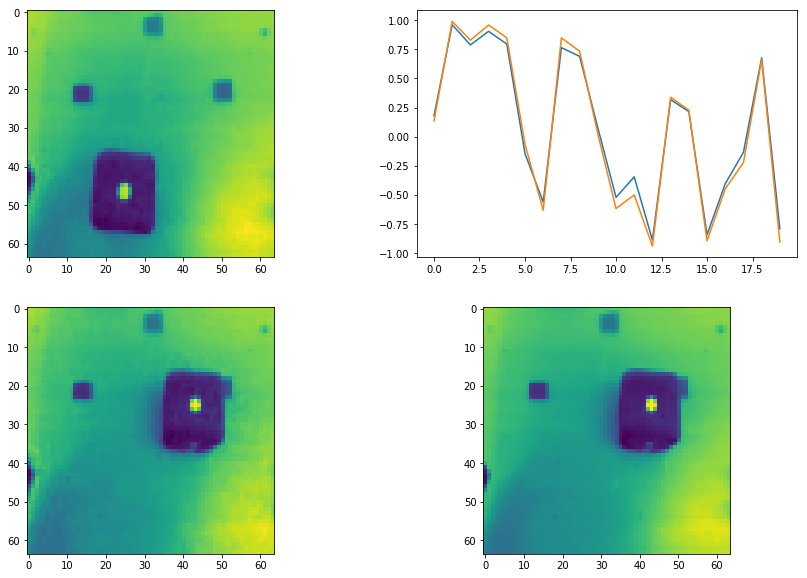

In [69]:
%matplotlib inline
pos, vel = get_cur_joints(torobo)
img = cv2.resize(imagebuff, (64,64), interpolation = cv2.INTER_AREA)/255.
img = np.expand_dims(img, 0)

visual_input = torch.tensor(img, dtype=torch.float).sum(axis=3).view(-1, 1, 64, 64).to(device)/3.
motor_input = torch.tensor(np.radians(pos), dtype=torch.float).view(-1,16).to(device)/2.

with torch.no_grad():
    _, _, mu, _ = vae(visual_input, motor_input, False) 
    hidden = mu.unsqueeze(1)/2.

    visual_output, motor_output, hidden = rnn(visual_input,
                                          motor_input, hidden)
    
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2 ,2, figsize=(15,10))
ax0.imshow(visual_output.cpu().squeeze())
ax1.plot(hidden.cpu().detach().numpy().squeeze())

# -------------------------------------------------------------------------------------

visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)

with torch.no_grad():
    _, _, mu, _ = vae(visual_input[0].unsqueeze(0), motor_input[0].unsqueeze(0), False) 
    hidden = mu.unsqueeze(1)/2.

visual_output, motor_output, hidden = rnn(visual_input[0,:,:,:].view(-1,1,64,64),
                                          motor_input[0,:].view(-1, motor_input_size),
                                          hidden)

ax2.imshow(visual_output.cpu().detach().numpy().squeeze())
ax1.plot(hidden.cpu().detach().numpy().squeeze())
ax3.imshow(visual_input[0,:,:,:].view(-1,1,64,64).cpu().detach().numpy().squeeze())

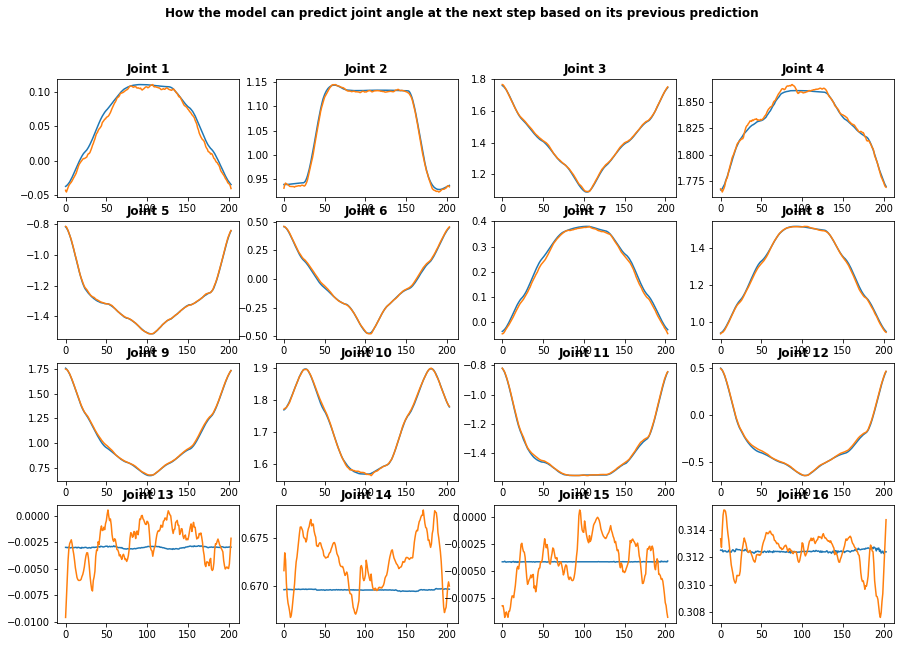

In [70]:
visual_input, motor_input, visual_target, motor_target = dl.get_sample(device)

with torch.no_grad():
    _, _, mu, _ = vae(visual_input[0].unsqueeze(0), motor_input[0].unsqueeze(0), False) 
    hidden = mu.unsqueeze(1)/2.

motor_output = motor_input[0,:]

gt, pred = [], []
for i in range(1, len(visual_input)):
    visual_output, motor_output, hidden = rnn(visual_input[i,:,:,:].view(-1,1,64,64),
                                              motor_output.view(-1, motor_input_size),
                                              hidden)
    
    gt.append(motor_target[i,:].detach().cpu().numpy())
    pred.append(motor_output.squeeze().detach().cpu().numpy())
gt = np.stack(gt) * 2.
pred = np.stack(pred) * 2.


plt.figure(figsize=(15,10))
plt.suptitle('How the model can predict joint angle at the next step based on its previous prediction', weight='bold')
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title('Joint {}'.format(i+1), weight='bold')
    plt.plot(gt[:, i])
    plt.plot(pred[:, i])

In [71]:
""" New steps are based on previously predicted ones """

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

with HiddenPrints():
    set_softness_override(torobo, 10.0)
    set_velocity_override(torobo, 10.0)
    time.sleep(0.5)
    torobo.set_control_mode(ToroboOperator.LEFT_ARM,
                        'all',
                        'external_force_following_online_trajectory')
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM,
                            'all',
                            'external_force_following_online_trajectory')
    torobo.set_control_mode(ToroboOperator.TORSO_HEAD,
                            ['torso_head/joint_3', 'torso_head/joint_4'],
                            'external_force_following_online_trajectory')
    time.sleep(0.5)

DUR = 0.15

# get the initial hidden state corresponding to the position of the cube
img = cv2.resize(imagebuff, (64,64), interpolation = cv2.INTER_AREA)/255.
img = np.expand_dims(img, 0)
visual_input = torch.tensor(img, dtype=torch.float).sum(axis=3).view(-1, 1, 64, 64).to(device) / 3.
motor_input = torch.tensor(np.radians(pos), dtype=torch.float).view(1,16).to(device) / 2.
with torch.no_grad():
    _, _, mu, _ = vae(visual_input.view(-1,1,64,64),
                      motor_input.view(-1,motor_input_size),
                      False) 
    hidden = mu.unsqueeze(1)/2.

FF = []   
while True:
    
    # read the current joints
    pos, vel = get_cur_joints(torobo)
    
    # we take the image at the current step from the camera
    img = cv2.resize(imagebuff, (64,64), interpolation = cv2.INTER_AREA)/255.
    img = np.expand_dims(img, 0)
    
    # normalize visual and motor data
    visual_input = torch.tensor(img, dtype=torch.float).sum(axis=3).view(-1, 1, 64, 64).to(device) / 3.
    
    # forward the inputs
    visual_output, motor_input, hidden = rnn(visual_input,
                                             motor_input.view(1,motor_input_size),
                                             hidden)
    
    OUT = motor_input.cpu().detach().numpy() * 2.0

    left_arm_positions = OUT.reshape(1, 16)[0, 0:6]
    right_arm_positions = OUT.reshape(1, 16)[0, 6:12]


    torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=DUR)
    torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=DUR)
    time.sleep(DUR-0.05)
    
    
    
    real_motor = torch.tensor(np.radians(pos), dtype=torch.float).view(-1,16).to(device) / 2.
    motor_input = 0.5 * motor_input + 0.5 * real_motor
    
    im2 = cv2.resize(visual_output.squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
    im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    im3 = cv2.resize(imagebuff, (350, 350), interpolation = cv2.INTER_AREA)
    im3 = cv2.normalize(im3, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    final_frame = cv2.hconcat((im3[:,:,2], im2))
    cv2.imshow('I see', final_frame)

    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break
    i += 1
    FF.append(final_frame)
    

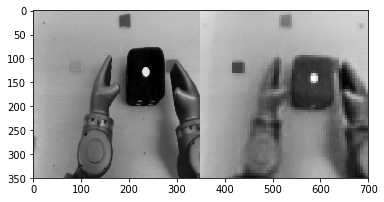

In [14]:
plt.imshow(final_frame, cmap='gray')

In [72]:
FF[0].shape

(350, 700)

In [48]:
FF[0].max()

1.0

In [74]:
import imageio
imageio.mimwrite('output_filename.mp4', np.stack(FF) , fps=10)

In [57]:
np.stack(FF).shape

(1855, 350, 700)